# General Adversarial Networks

> A small port of https://www.datacamp.com/community/tutorials/generative-adversarial-networks in tensorflow keras API in Python 3

> Further tensorflow eager execution with its new Data API will be added

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import tensorflow as tf

In [3]:
np.random.seed(10)

In [4]:
random_dim = [100,]

In [5]:
# TRAINING_SIZE = len(train_images)
# TEST_SIZE = len(test_images)
def load_minst_data():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    # Convert the array to float32 as opposed to uint8
    train_images = train_images.astype(np.float32)
    # test_images = test_images.astype(np.float32)

    # Convert the pixel values from integers between 0 and 255 to floats between 0 and 1
    train_images /= 255
    # test_images /=  255

    X = np.reshape(train_images, [-1, 28*28])
    return (X, train_labels, test_images, test_labels)
# NUM_DIGITS = 10

# Y  = tf.one_hot(train_labels, NUM_DIGITS)

# test_labels = tf.keras.utils.to_categorical(test_labels, NUM_DIGITS)

In [6]:
def get_optimizer():
    return tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5)

In [7]:
def get_generator(optimizer):
    generator = tf.keras.models.Sequential()
    generator.add(tf.keras.layers.Dense(256, input_shape=random_dim, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    generator.add(tf.keras.layers.LeakyReLU(0.2))
    
    generator.add(tf.keras.layers.Dense(512))
    generator.add(tf.keras.layers.LeakyReLU(0.2))
    
    generator.add(tf.keras.layers.Dense(1024))
    generator.add(tf.keras.layers.LeakyReLU(0.2))
    
    generator.add(tf.keras.layers.Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [8]:
def get_discriminator(optimizer):
    discriminator = tf.keras.models.Sequential()
    discriminator.add(tf.keras.layers.Dense(1024, input_shape=[784,], kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    discriminator.add(tf.keras.layers.Dropout(0.3))
    
    discriminator.add(tf.keras.layers.Dense(512))
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    discriminator.add(tf.keras.layers.Dropout(0.3))
    
    discriminator.add(tf.keras.layers.Dense(256))
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    discriminator.add(tf.keras.layers.Dropout(0.3))
    
    discriminator.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [9]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    discriminator.trainable = False
    gan_input = tf.keras.layers.Input(shape=random_dim)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = tf.keras.models.Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [10]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim[0]])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)


In [11]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = int(x_train.shape[0] / batch_size)

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim[0]])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim[0]])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 2 == 0:
            plot_generated_images(e, generator)


GANs are pretty tough to train. And on my low power laptop I couldn't train for long, for good result one should must train for 400 epochs.

  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  0%|          | 1/468 [00:00<00:48,  9.57it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/468 [00:00<00:42, 11.07it/s]

--------------- Epoch 3 ---------------


  0%|          | 1/468 [00:00<00:51,  9.07it/s]

--------------- Epoch 4 ---------------


  0%|          | 1/468 [00:00<00:49,  9.36it/s]

--------------- Epoch 5 ---------------


  0%|          | 2/468 [00:00<00:41, 11.15it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/468 [00:00<00:39, 11.70it/s]

--------------- Epoch 7 ---------------


  0%|          | 1/468 [00:00<00:52,  8.93it/s]

--------------- Epoch 8 ---------------


  0%|          | 2/468 [00:00<00:41, 11.10it/s]

--------------- Epoch 9 ---------------


  0%|          | 1/468 [00:00<00:52,  8.90it/s]

--------------- Epoch 10 ---------------


100%|██████████| 468/468 [00:44<00:00, 10.55it/s]


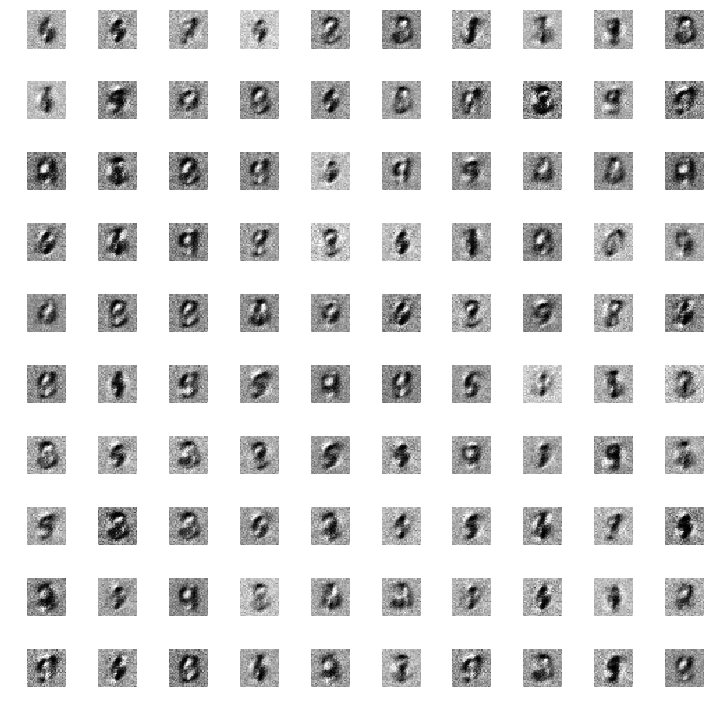

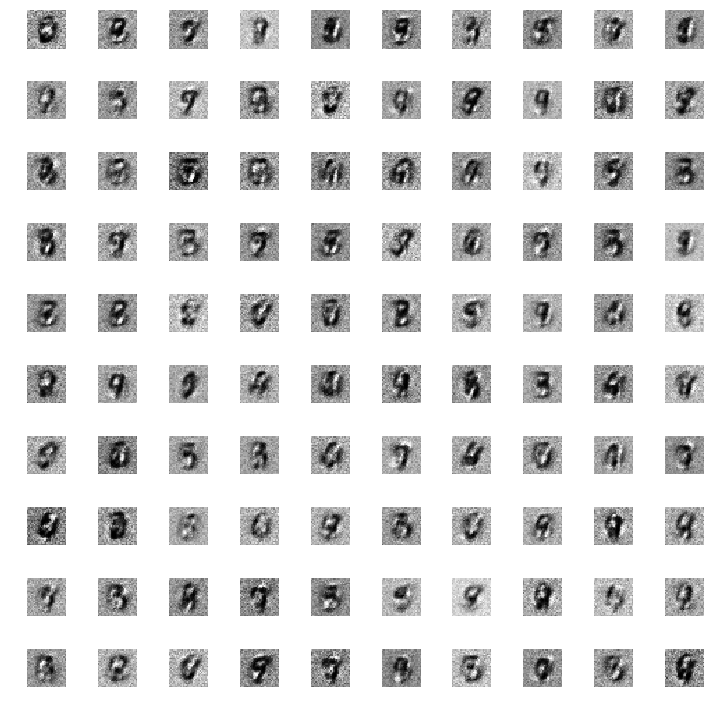

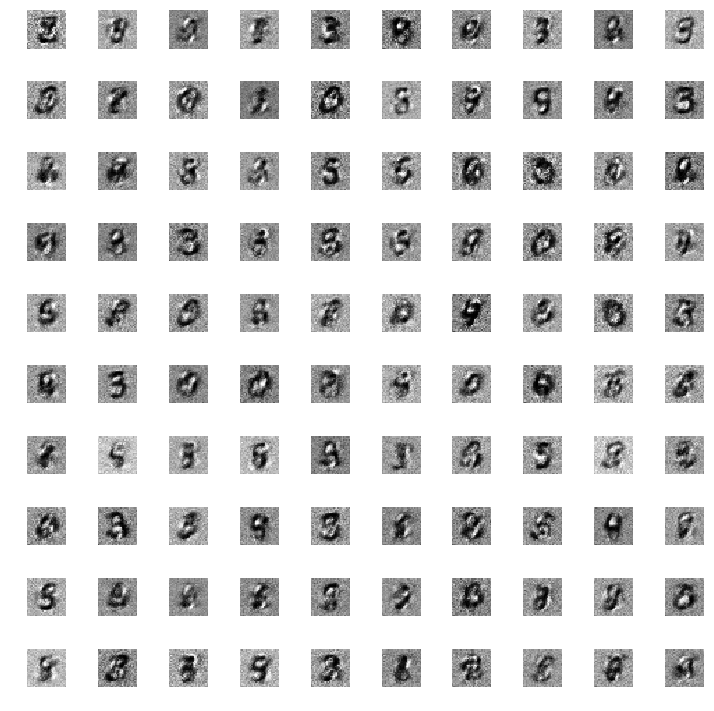

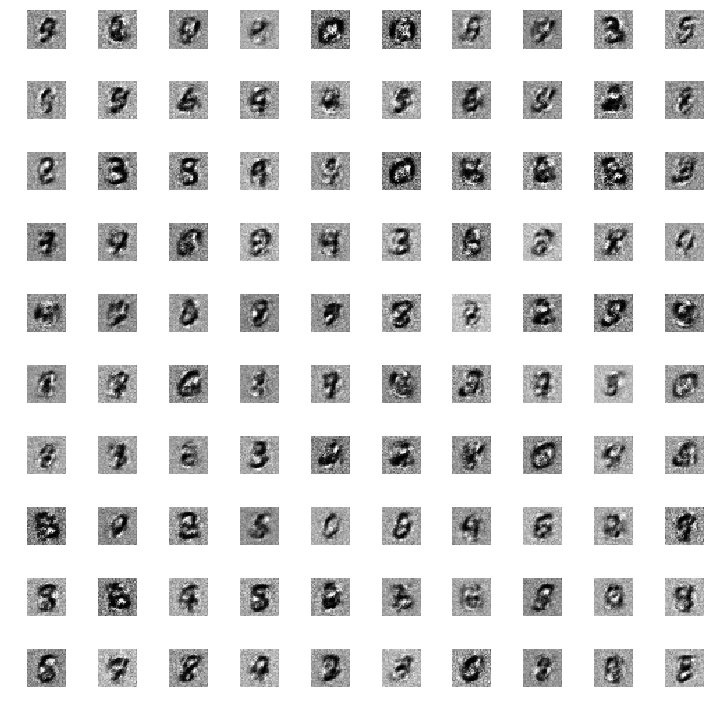

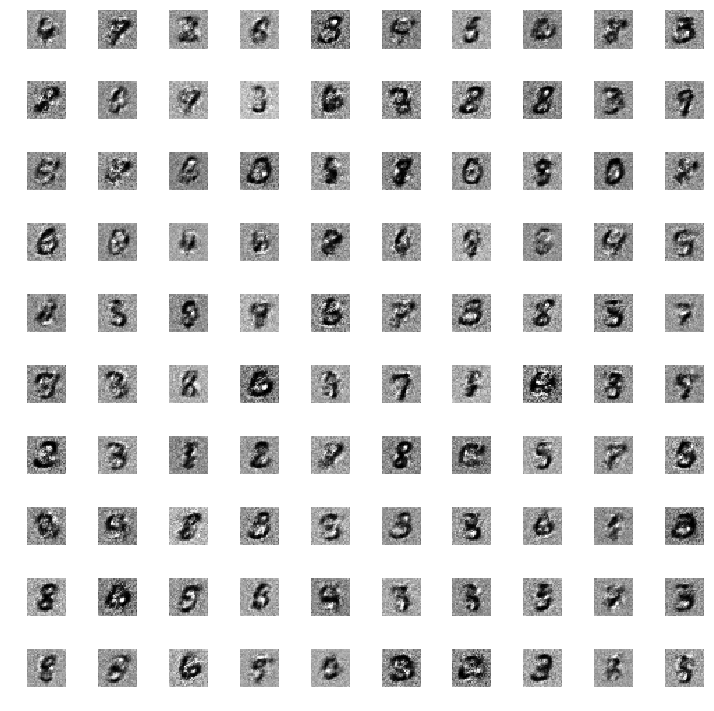

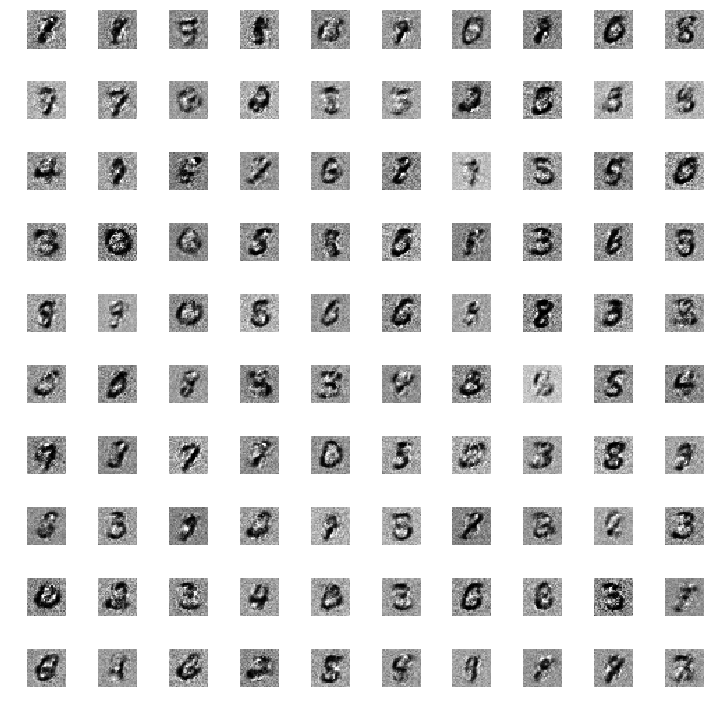

In [14]:
train(10, 128)

  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:46<00:00, 10.04it/s]


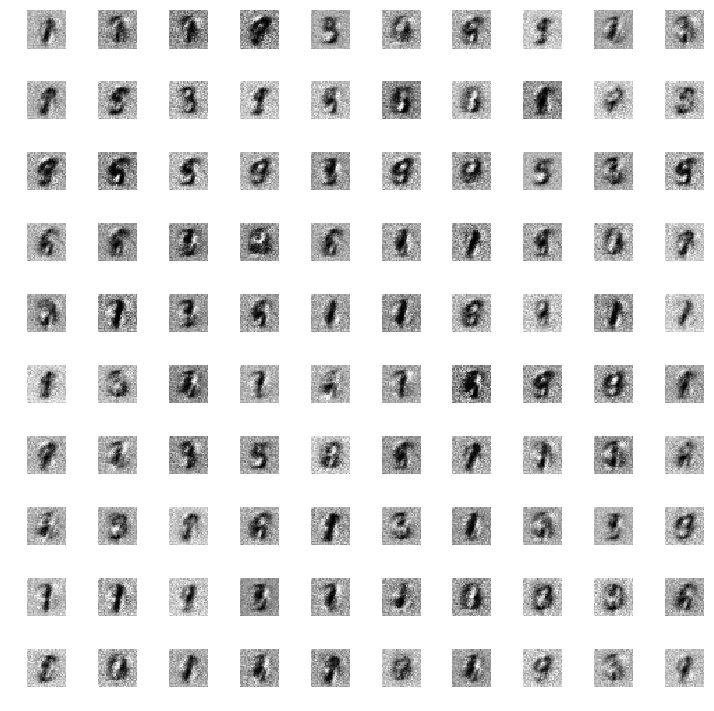

In [15]:
train(1, 128)